# imports

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopy
from geopy import distance
import math

import scipy
from scipy import stats
from itertools import combinations

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special
from scipy import spatial

import figurefirst as fifi
import time



# spatial analysis


In [2]:
def spatialchanges (dir_df, speed_df, x_position,y_position,z_position, radians=False):
    '''
this takes the difference between 2 sensors for all possible combinations. Returns a df sorted by distance
    
    dir_df - all columns of directional data from one data collection, assumed to be in range 0-360
    
    speed_df - all columns of horizontal speed data from one data collection
    
    latlons - list of tuples in form (lat, lon) which correspond to dir_df and speed_df

all inputs are expected to be organized alphabetically/numerically from sensor A (1) to I (9) 
    
    '''    
    def combine(arr, s):  #to determine total permutation of sensor pairs
        return list(combinations(arr, s)) 
    
    ########this is for direction 
    if (radians==True): #to convert into degrees if needed
        dir_df=dir_df*180/np.pi
    if (any(np.max(dir_df, axis=0)) > 360 or any(np.max(dir_df, axis=0)) < 0):
        raise ValueError ("Directional data not bounded correctly. Needs to be in range [0,360] or [0,2pi]")
    
    
    columns=np.arange(0,len(dir_df.T)) #count total number of sensor recordings in df - should be same for S2, direction and position dfs
    N=len(combine(columns, 2)) #compute total number of permutations for all 2 sensor pairs
    direction_diff_list=np.empty((N, 0)).tolist()
    speed_diff_list=np.empty((N, 0)).tolist()
    direction_avg_list=np.empty((N, 0)).tolist()
    speed_avg_list=np.empty((N, 0)).tolist()
    distances=np.empty((N, 0)).tolist()
    k=0
    
    for i in columns:
        totalcombinations=len(dir_df.T)-i
        for j in range (1, totalcombinations):
            
            direction_diff_list[k]=np.abs(dir_df.iloc[:,i]-dir_df.iloc[:,i+j]) #direction_diff
            speed_diff_list[k]=speed_df.iloc[:,i]-speed_df.iloc[:,i+j] #speed_diff
            speed_avg_list[k]=(np.abs(speed_df.iloc[:,i]+speed_df.iloc[:,i+j])/2) #gives average speed between two sensors
            
            angulardata=np.array([dir_df.iloc[:,i],dir_df.iloc[:,i+j]])
            direction_avg_list[k]=scipy.stats.circmean(angulardata*math.pi/180, axis=0)*180/math.pi #computes mean between 2 sensors at each time recording
            
            u=np.array([x_position.iloc[0,i],y_position.iloc[0,i],x_position.iloc[0,i]]) #sensor1
            v=np.array([x_position.iloc[0,i+j],y_position.iloc[0,i+j],x_position.iloc[0,i+j]]) #sensor2
            distances[k]= scipy.spatial.distance.euclidean(u,v)*1000 #distance between sensor1 and sensor2 in meters

            #distances[k]=distance.distance(latlons[i],latlons[i+j]).m #compute distance in meters from gps coords
            k=k+1

    direction_diff=pd.DataFrame(direction_diff_list, index=np.round(distances,decimals=2))
    
    #fixes the angles
    M=len(direction_diff)
    for x in range (0,M):
        for y in (np.where(direction_diff_list[x]>180)):
            direction_diff.iloc[x,y]=360-direction_diff.iloc[x,y] #maximum difference in angle can be 180 - if more than 180, will subtract to get the smaller angle
    
    direction_diff=direction_diff.sort_index(ascending=True).T
    
    direction_avg=pd.DataFrame(direction_avg_list, index=np.round(distances,decimals=2)).sort_index(ascending=True).T
    speed_diff=pd.DataFrame(speed_diff_list, index=np.round(distances,decimals=2)).sort_index(ascending=True).T  
    speed_avg=pd.DataFrame(speed_avg_list, index=np.round(distances,decimals=2)).sort_index(ascending=True).T       
    
    return (direction_diff, direction_avg, speed_diff, speed_avg)


In [3]:
#split speed and difference dfs so that you can find averages on different time chunks
def split_df(df, chunk_size = 6000): #default chunks are 10 min
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks 

def avg_df(chunks):
    avg_df=pd.DataFrame(index=chunks[0].columns)
    N=len(chunks)
    if len(chunks[-1])< len(chunks[0]):
        N=len(chunks)-1
    testdf=np.empty((N, 0)).tolist()
    for i in range(0,N):
        testdf[i]=pd.DataFrame(chunks[i].mean(), columns=[i])
        avg_df=pd.concat([avg_df, testdf[i]], axis=1)
    return avg_df

def avg_df_direction(chunks):
    avg_df=pd.DataFrame(index=chunks[0].columns)
    N=len(chunks)
    if len(chunks[-1])< len(chunks[0]):
        N=len(chunks)-1
    testdf=np.empty((N, 0)).tolist()    
    for i in range(0,N):
        testdf[i]=pd.DataFrame((scipy.stats.circmean(chunks[i]*np.pi/180, axis=0)*180/np.pi), columns=[i], index=chunks[0].columns)
        avg_df=pd.concat([avg_df, testdf[i]], axis=1)
    return avg_df

def find_avg_values(direction_diff, direction_avg, speed_diff, speed_avg):
    new_direction_diff=avg_df(split_df(direction_diff))
    new_direction_avg=avg_df_direction(split_df(direction_avg))
    new_speed_diff=avg_df(split_df(speed_diff))
    new_speed_avg=avg_df(split_df(speed_avg))
    
    return new_direction_diff, new_direction_avg, new_speed_diff,new_speed_avg

# read in data

In [4]:
#wind data -- can download from figshare
df=pd.read_hdf('small_7.7.21_maskedgpsdata.hdf')
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.time.iloc[0]))

'2021-07-07 10:17:43'

In [5]:
#check for nan before running anything
df.isnull().values.any()

False

In [6]:
print(df.keys()) #figure out what sensors are available to compute spatial differences between 

Index(['time', 'S2_1', 'D_1', 'X_1', 'Y_1', 'Z_1', 'S2_2', 'D_2', 'X_2', 'Y_2',
       'Z_2', 'S2_3', 'D_3', 'X_3', 'Y_3', 'Z_3', 'S2_4_verticallyorientated',
       'D_4_verticallyorientated', 'X_4_verticallyorientated',
       'Y_4_verticallyorientated', 'Z_4_verticallyorientated', 'S2_5', 'D_5',
       'X_5', 'Y_5', 'Z_5', 'S2_6', 'D_6', 'X_6', 'Y_6', 'Z_6', 'S2_8', 'D_8',
       'X_8', 'Y_8', 'Z_8', 'S2_9', 'D_9', 'X_9', 'Y_9', 'Z_9',
       'S2_7_verticallyorientated', 'D_7_verticallyorientated',
       'X_7_verticallyorientated', 'Y_7_verticallyorientated',
       'Z_7_verticallyorientated', 'U_4_verticallyorientated',
       'V_4_verticallyorientated', 'U_7_verticallyorientated',
       'V_7_verticallyorientated'],
      dtype='object')


In [7]:
#forest 7.7.21 - vertical sensors were D (4) and G (7) - those should not be included.

#create separate dfs - (1) horizontal direction, (2) horizontal speed, (3) x position, (4) y position,(5) z position
df_dir=df[['D_1','D_2', 'D_3', 'D_5', 'D_6',  'D_8', 'D_9']]
df_speeds=df[[ 'S2_1', 'S2_2', 'S2_3', 'S2_5','S2_6', 'S2_8', 'S2_9']]
df_x=df[['X_1','X_2','X_3', 'X_5', 'X_6', 'X_8', 'X_9']]
df_y=df[['Y_1','Y_2', 'Y_3', 'Y_5','Y_6', 'Y_8', 'Y_9']]
df_z=df[['Z_1','Z_2', 'Z_3', 'Z_5','Z_6','Z_8', 'Z_9']]



In [8]:
#calculate the difference in direction, difference in speed, avg direction, and avg speed between each pair of sensors at all points in time series
direction_diff, direction_avg, speed_diff, speed_avg = spatialchanges(df_dir, df_speeds, df_x, df_y, df_z)
# find the 10 min averages 
direction_diff_10min, direction_avg_10min, speed_diff_10min, speed_avg_10min = find_avg_values(direction_diff, direction_avg, speed_diff, speed_avg)

In [9]:
#control data from the same date/time as our wind data - WRCC managed tower (https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?nvsagh);
control_station_data=pd.read_excel('WRCC data/7.7.21_WRCC.xls',  names=['Date time',  'Mean Wind Speed', 'Wind Vector Magnitude', 'Mean Wind Direction', 'Std Deviation of Wind Direction', 'Mean Wind Speed 100ft', 'Wind Vector Speed 100ft', 'Wind Direction 100ft', 'Std Dev of Wind Direction 100ft' ])
control_station_data

,Date time,Mean Wind Speed,Wind Vector Magnitude,Mean Wind Direction,Std Deviation of Wind Direction,Mean Wind Speed 100ft,Wind Vector Speed 100ft,Wind Direction 100ft,Std Dev of Wind Direction 100ft
0,2107071020,1.348,1.050,256.6,38.09,3.719,3.377,256.3,24.57
1,2107071030,1.363,1.026,274.5,39.28,3.328,2.762,254.8,33.41
2,2107071040,1.367,0.483,302.0,65.12,3.849,2.743,221.1,43.42
3,2107071050,1.245,0.306,230.8,70.37,3.022,2.298,196.7,39.66
4,2107071100,1.819,0.825,254.5,59.88,4.718,3.662,239.3,38.32
5,2107071110,0.870,0.389,240.5,60.20,2.656,2.224,232.4,32.67
6,2107071120,1.258,0.814,277.6,48.12,3.240,3.033,251.6,20.48
7,2107071130,1.452,0.974,252.2,46.47,3.424,3.118,257.8,24.19
8,2107071140,1.358,0.872,231.3,48.49,3.536,3.133,263.9,27.36
9,2107071150,1.475,1.064,268.5,42.75,3.959,3.529,270.0,26.70


In [10]:
print(len(control_station_data),len(direction_diff_10min.columns))

22 22


In [ ]:
# should produce a df with # of rows = NxM of 10 min avg dfs 
reorg_ddf=pd.DataFrame(columns = ['distance','speed_avg', 'direction_avg', 'direction_diff', 'speed_diff', 'control_D_100', 'control_S2_100'])
i=0
for k in direction_avg_10min.index:
    xtra = {'distance': k,
           'direction_avg': direction_avg_10min.iloc[i,:],
            'direction_diff': direction_diff_10min.iloc[i,:],
            'speed_avg': speed_avg_10min.iloc[i,:],
            'speed_diff': speed_diff_10min.iloc[i,:],
            'control_S2_100': control_station_data['Mean Wind Speed 100ft'],
            'control_D_100': control_station_data['Std Dev of Wind Direction 100ft'],
           }
    reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
    i=i+1

In [12]:
#reorg_ddf.speed=reorg_ddf.index #give avg speed its own column
reorg_ddf.reset_index(inplace=True)
#rename index to environment and assign column value based on environment
reorg_ddf.rename(columns={'index':'environment'}, inplace=True)
reorg_ddf[['environment']]=.4 # [.001 - Black Rock, .04 - Lemmon Valley, .4 - Tahoe Forest, 1 - Urban]
reorg_ddf[['group']]=2 # ordered from 1-16 based on date of collection
reorg_ddf

,environment,distance,speed_avg,direction_avg,direction_diff,speed_diff,control_D_100,control_S2_100,group
0,0.4,7.15,1.894042,273.077348,31.937167,-0.620823,24.57,3.719,2
1,0.4,7.15,1.238175,272.443650,43.233000,-0.157520,33.41,3.328,2
2,0.4,7.15,1.415543,277.816529,46.784833,-0.254663,43.42,3.849,2
3,0.4,7.15,2.065814,291.613065,34.564667,-0.691035,39.66,3.022,2
4,0.4,7.15,1.556356,277.476457,47.731833,-0.354015,38.32,4.718,2
...,...,...,...,...,...,...,...,...,...
457,0.4,48.19,2.236612,224.015241,36.224500,0.881410,44.08,3.053,2
458,0.4,48.19,2.375068,220.289038,37.349167,0.329583,33.99,3.965,2
459,0.4,48.19,2.038414,240.323820,49.356833,0.322578,31.02,4.806,2
460,0.4,48.19,2.609963,220.207685,37.783333,0.784405,20.48,6.270,2


In [12]:
#adding some other columns that are useful for regression analysis
reorg_ddf['cos_direction_avg']=np.cos(reorg_ddf.direction_avg*np.pi/180)
reorg_ddf['sin_direction_avg']=np.sin(reorg_ddf.direction_avg*np.pi/180)
reorg_ddf['speed_diff_abs']=np.abs(reorg_ddf.speed_diff)
reorg_ddf


,distance,speed_avg,direction_avg,direction_diff,speed_diff,control_D_100,control_S2_100,cos_direction_avg,sin_direction_avg,speed_diff_abs
0,7.15,1.894042,273.077348,31.937167,-0.620823,24.57,3.719,0.053684,-0.998558,0.620823
1,7.15,1.238175,272.443650,43.233000,-0.157520,33.41,3.328,0.042637,-0.999091,0.157520
2,7.15,1.415543,277.816529,46.784833,-0.254663,43.42,3.849,0.136001,-0.990709,0.254663
3,7.15,2.065814,291.613065,34.564667,-0.691035,39.66,3.022,0.368337,-0.929693,0.691035
4,7.15,1.556356,277.476457,47.731833,-0.354015,38.32,4.718,0.130119,-0.991498,0.354015
...,...,...,...,...,...,...,...,...,...,...
17,48.19,2.236612,224.015241,36.224500,0.881410,44.08,3.053,-0.719155,-0.694850,0.881410
18,48.19,2.375068,220.289038,37.349167,0.329583,33.99,3.965,-0.762792,-0.646644,0.329583
19,48.19,2.038414,240.323820,49.356833,0.322578,31.02,4.806,-0.495098,-0.868837,0.322578
20,48.19,2.609963,220.207685,37.783333,0.784405,20.48,6.270,-0.763709,-0.645560,0.784405


In [14]:
reorg_ddf.to_hdf('7.7.21_spatial.hdf', key='/windgps')

## Visualizing the data

In [2]:
df1=pd.read_hdf('dfs_for_spatialregression/10.20.20_spatial.hdf')
df2=pd.read_hdf('dfs_for_spatialregression/7.7.21_spatial.hdf')
df3=pd.read_hdf('dfs_for_spatialregression/9.26.21_spatial.hdf')
df4=pd.read_hdf('dfs_for_spatialregression/10.29.21_spatial.hdf')
df5=pd.read_hdf('dfs_for_spatialregression/10.30.21_spatial.hdf')
df6=pd.read_hdf('dfs_for_spatialregression/1.8.22_spatial.hdf')
df7=pd.read_hdf('dfs_for_spatialregression/1.11.22_spatial.hdf')
df8=pd.read_hdf('dfs_for_spatialregression/1.15.22_spatial.hdf')
df9=pd.read_hdf('dfs_for_spatialregression/4.30.22_spatial.hdf')
df10=pd.read_hdf('dfs_for_spatialregression/5.1.22_spatial.hdf')
df11=pd.read_hdf('dfs_for_spatialregression/5.2.22_spatial.hdf')
df12=pd.read_hdf('dfs_for_spatialregression/6.1.22_spatial.hdf')
df13=pd.read_hdf('dfs_for_spatialregression/6.3.22_spatial.hdf')
df14=pd.read_hdf('dfs_for_spatialregression/6.7.22_spatial.hdf')
df15=pd.read_hdf('dfs_for_spatialregression/6.8.22_spatial.hdf')
df16=pd.read_hdf('dfs_for_spatialregression/6.22.22_spatial.hdf')
df1

,environment,distance,speed_avg,direction_avg,direction_diff,speed_diff,control_D_100,control_S2_100,group,cos_direction_avg,sin_direction_avg,speed_diff_abs
0,0.001,21.45,1.349808,105.257773,28.590000,0.109370,35.77,1.632,1.0,-0.263162,0.964752,0.109370
1,0.001,21.45,1.431984,145.077525,24.039667,-0.026000,18.84,2.379,1.0,-0.819927,0.572468,0.026000
2,0.001,21.45,1.619160,149.547802,25.115167,0.057457,21.28,2.085,1.0,-0.862052,0.506819,0.057457
3,0.001,21.45,1.721084,149.399888,20.926833,-0.168135,24.45,1.366,1.0,-0.860741,0.509043,0.168135
4,0.001,21.45,1.784912,179.502089,27.386333,-0.020310,30.68,2.284,1.0,-0.999962,0.008690,0.020310
...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.001,119.87,4.984498,205.540113,5.844500,0.510947,35.97,1.352,1.0,-0.902284,-0.431143,0.510947
556,0.001,119.87,4.618164,202.926146,5.876667,0.637965,45.82,0.919,1.0,-0.921008,-0.389544,0.637965
557,0.001,119.87,5.150205,206.196001,4.783500,0.786037,39.60,1.247,1.0,-0.897289,-0.441443,0.786037
558,0.001,119.87,5.431272,205.256679,4.012833,0.511593,49.58,1.132,1.0,-0.904405,-0.426674,0.511593


In [3]:
desertchunks=pd.concat([df1, df7,df8,df12,df13])
forestchunks=pd.concat([df2,df4,df14,df15,df16])
urbanchunks=pd.concat([df3,df5,df6,df9,df10,df11])
allchunks=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]
alldf=pd.concat(allchunks)
desert=0,6,7,11,12
forest=1,3,13,14,15
urban=2,4,5,8,9,10

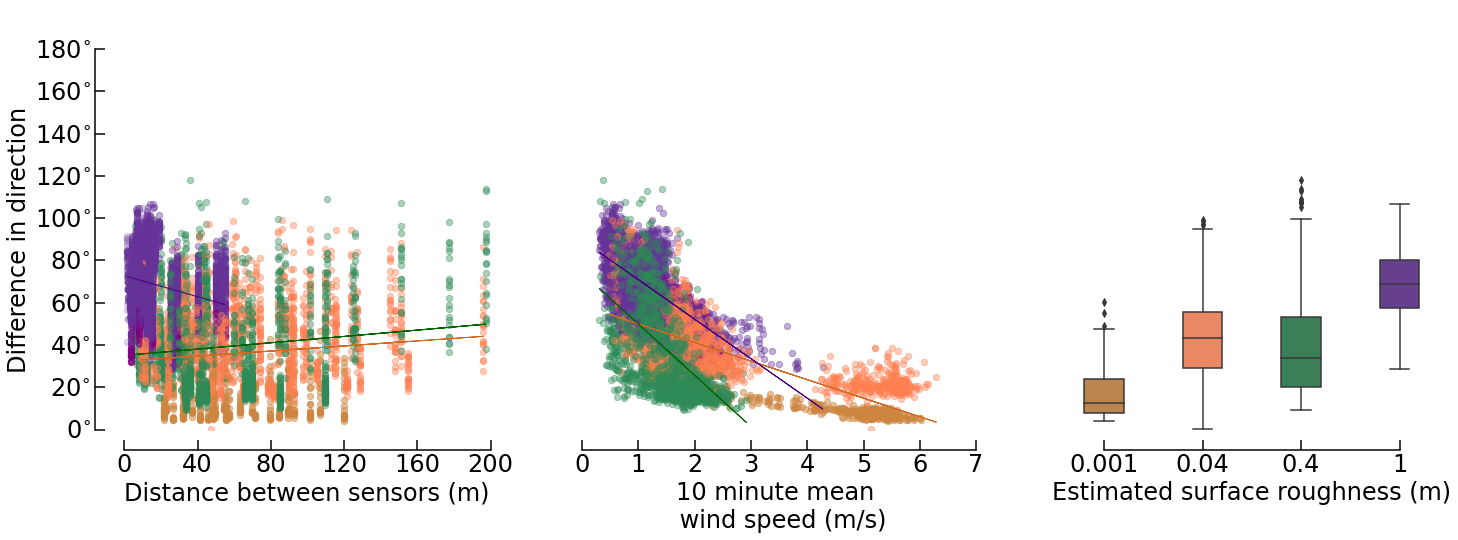

In [12]:
mpl.rcParams.update({'font.size': 24})
allchunks=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]
c=['peru', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7), rasterized=True)

ax[0].scatter(allchunks[0].distance, allchunks[0].direction_diff, s=40, color=c[0], alpha=.5, label='desert/valley')
ax[1].scatter(allchunks[0].speed_avg, allchunks[0].direction_diff,  s=40, color=c[0], alpha=.5, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].direction_diff, s=40, color=c[1], alpha=.4, label='forest')
ax[1].scatter(allchunks[1].speed_avg, allchunks[1].direction_diff,  s=40, color=c[1], alpha=.4, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].direction_diff, s=40, color=c[2], alpha=.2, label='urban')
ax[1].scatter(allchunks[2].speed_avg, allchunks[2].direction_diff,  s=40, color=c[2], alpha=.4, label='urban')

# add mean lines
slope, intercept = np.polyfit(desertchunks.distance, desertchunks.direction_diff, 1)
abline_values = [slope * i + intercept for i in desertchunks.distance]
ax[0].plot(desertchunks.distance, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.distance, forestchunks.direction_diff, 1)
abline_values = [slope * i + intercept for i in forestchunks.distance]
ax[0].plot(forestchunks.distance, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.distance, urbanchunks.direction_diff, 1)
abline_values = [slope * i + intercept for i in urbanchunks.distance]
ax[0].plot(urbanchunks.distance, abline_values, 'indigo', linewidth=1)


slope, intercept = np.polyfit(desertchunks.speed_avg, desertchunks.direction_diff, 1)
abline_values = [slope * i + intercept for i in desertchunks.speed_avg]
ax[1].plot(desertchunks.speed_avg, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.speed_avg, forestchunks.direction_diff, 1)
abline_values = [slope * i + intercept for i in forestchunks.speed_avg]
ax[1].plot(forestchunks.speed_avg, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.speed_avg, urbanchunks.direction_diff, 1)
abline_values = [slope * i + intercept for i in urbanchunks.speed_avg]
ax[1].plot(urbanchunks.speed_avg, abline_values, 'indigo', linewidth=1)

for i in range(3,16):
    ax[0].scatter(allchunks[i].distance, allchunks[i].direction_diff, s=40, color=c[i], alpha=.4)
    ax[1].scatter(allchunks[i].speed_avg, allchunks[i].direction_diff,  s=40, color=c[i], alpha=.4)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.direction_diff, showfliers=True, palette=['peru','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[2].set_xticklabels([.001,.04, .4, 1])
ax[0].set_ylim(0,180)
ax[1].set_ylim(0,180) 
ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,3.5) 
#ax[0].set_xlim(0,100)
ax[0].set_ylabel('Difference in direction')
ax[0].set_xlabel('Distance between sensors (m)')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute mean \n wind speed (m/s)')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness (m)')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

#ax[0].legend(bbox_to_anchor=(1,1))
#ax[1].legend(bbox_to_anchor=(1,1))
#ax[2].legend(bbox_to_anchor=(1,1))



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=[0,20,40,60,80,100,120,140,160,180],
                                 xticks=[0,40,80,120,160, 200],
                                 tick_length=10,
                                 spine_locations={'left': 15, 'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,1,2,3,4, 5,6,7],
                                 tick_length=10,
                                 spine_locations={'bottom':20},
                                 linewidth=1.5)


# set yticklabels
#evenyticks = np.arange(0, 180+20, 20)
#yticklabels = [['$' + str(y) + '^{\circ}$', ''] for y in evenyticks]
#yticklabels = np.ravel(yticklabels)[0:-1]
#ax[0].set_yticklabels(yticklabels)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 
                                 tick_length=10,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)





evenyticks=np.arange(0, 200, 20)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax[0].set_yticklabels(yticklabels)



fig.savefig('regressionvariables_direction_spatial.svg', bbox_inches='tight', dpi=600, format='svg')

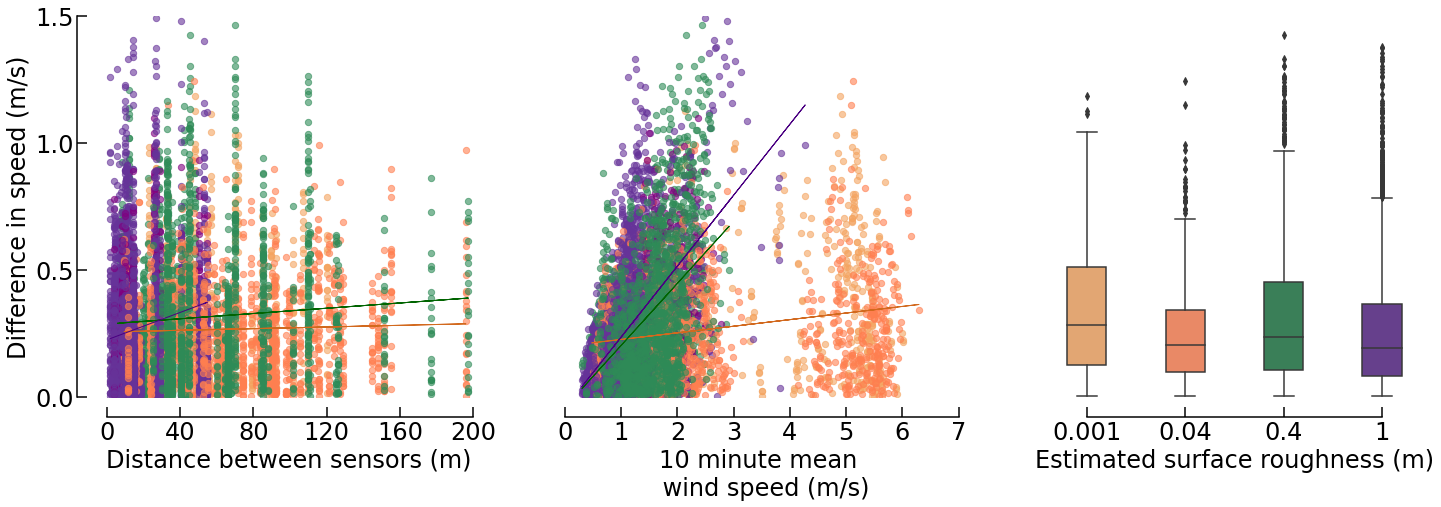

In [57]:
mpl.rcParams.update({'font.size': 24})

c=['sandybrown', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7), rasterized=True)

ax[0].scatter(allchunks[0].distance, allchunks[0].speed_diff_abs, s=40, color=c[0], alpha=.6, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].speed_diff_abs, s=40, color=c[1], alpha=.6, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].speed_diff_abs, s=40, color=c[2], alpha=.6, label='urban')

ax[1].scatter(allchunks[0].speed_avg, allchunks[0].speed_diff_abs,  s=40, color=c[0], alpha=.6, label='desert/valley')
ax[1].scatter(allchunks[1].speed_avg, allchunks[1].speed_diff_abs,  s=40, color=c[1], alpha=.6, label='forest')
ax[1].scatter(allchunks[2].speed_avg, allchunks[2].speed_diff_abs,  s=40, color=c[2], alpha=.6, label='urban')


# add mean lines
slope, intercept = np.polyfit(desertchunks.distance, desertchunks.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in desertchunks.distance]
ax[0].plot(desertchunks.distance, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.distance, forestchunks.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in forestchunks.distance]
ax[0].plot(forestchunks.distance, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.distance, urbanchunks.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in urbanchunks.distance]
ax[0].plot(urbanchunks.distance, abline_values, 'indigo', linewidth=1)


slope, intercept = np.polyfit(desertchunks.speed_avg, desertchunks.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in desertchunks.speed_avg]
ax[1].plot(desertchunks.speed_avg, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.speed_avg, forestchunks.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in forestchunks.speed_avg]
ax[1].plot(forestchunks.speed_avg, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.speed_avg, urbanchunks.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in urbanchunks.speed_avg]
ax[1].plot(urbanchunks.speed_avg, abline_values, 'indigo', linewidth=1)



for i in range(3,16):
    ax[0].scatter(allchunks[i].distance,  allchunks[i].speed_diff_abs, s=40, color=c[i], alpha=.6)
    ax[1].scatter(allchunks[i].speed_avg, allchunks[i].speed_diff_abs,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].direction_avg, allchunks[i].speed_diff,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.speed_diff_abs, showfliers=True, palette=['sandybrown','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[2].set_xticklabels([.001,.04, .4, 1])
#ax[1].set_ylim(0,180) 
#ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,360) 
ax[0].set_ylim(0,1.5)
ax[1].set_ylim(0,1.5)
ax[2].set_ylim(0,1.5)
ax[0].set_ylabel('Difference in speed (m/s)')
ax[0].set_xlabel('Distance between sensors (m)')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute mean \n wind speed (m/s)')
#ax[2].set_xlabel('cos(10 minute average direction)')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness (m)')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

#ax[0].legend(bbox_to_anchor=(1,1))
#ax[1].legend(bbox_to_anchor=(.78,1))
#ax[2].legend(bbox_to_anchor=(1,1))





fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=[0,0.5,1.0,1.5,],
                                 xticks=[0,40,80,120,160, 200],
                                 tick_length=10,
                                 spine_locations={'left': 15, 'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,1,2,3,4, 5,6,7],
                                 tick_length=10,
                                 spine_locations={'bottom':20},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 
                                 tick_length=10,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)




#fig.savefig('regressionvariables_speeddiffabs_spatial.svg', bbox_inches='tight', dpi=600, format='svg')

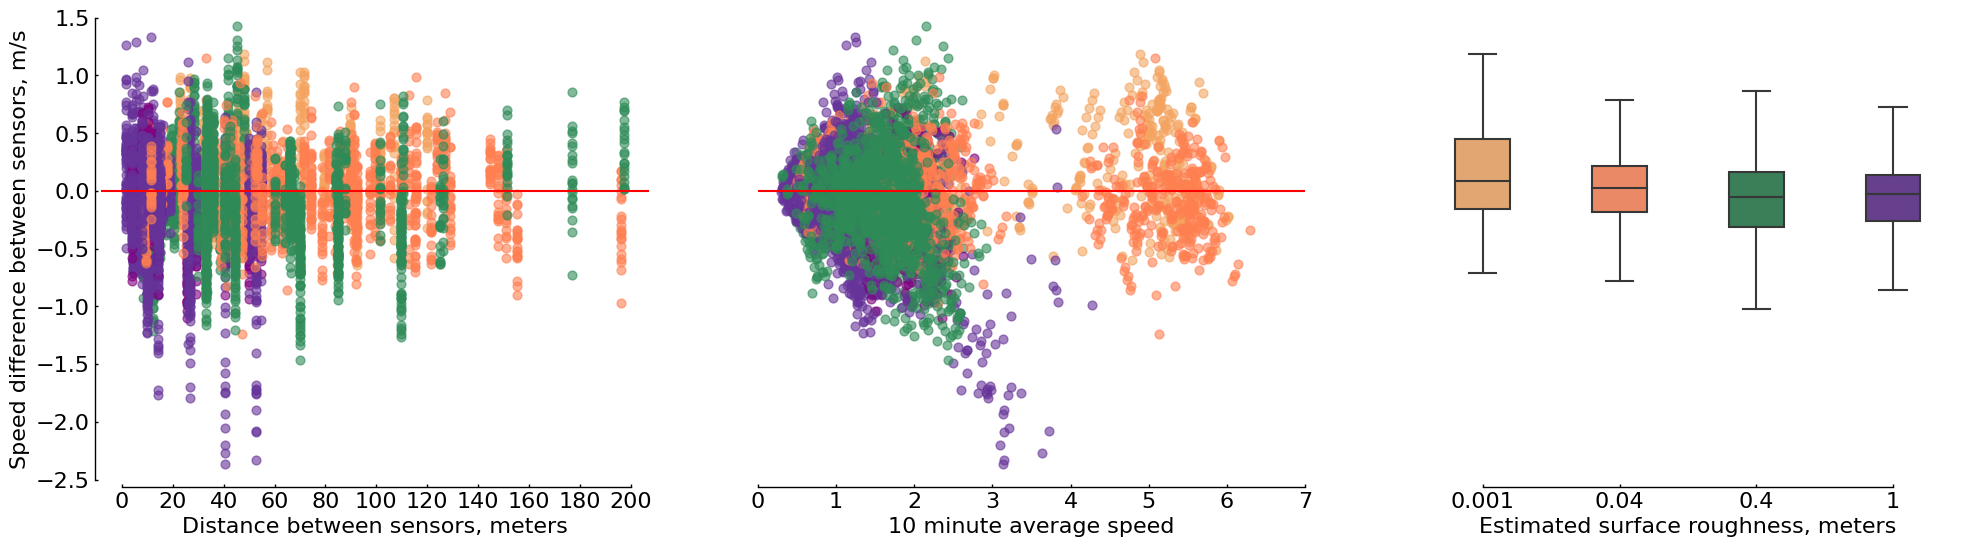

In [58]:
mpl.rcParams.update({'font.size': 16})

c=['sandybrown', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,6), rasterized=True)

ax[0].scatter(allchunks[0].distance, allchunks[0].speed_diff, s=40, color=c[0], alpha=.6, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].speed_diff, s=40, color=c[1], alpha=.6, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].speed_diff, s=40, color=c[2], alpha=.6, label='urban')

ax[1].scatter(allchunks[0].speed_avg, allchunks[0].speed_diff,  s=40, color=c[0], alpha=.6, label='desert/valley')
ax[1].scatter(allchunks[1].speed_avg, allchunks[1].speed_diff,  s=40, color=c[1], alpha=.6, label='forest')
ax[1].scatter(allchunks[2].speed_avg, allchunks[2].speed_diff,  s=40, color=c[2], alpha=.6, label='urban')

ax[0].axhline(0, c='red')
ax[1].axhline(0, c='red')



for i in range(3,16):
    ax[0].scatter(allchunks[i].distance,  allchunks[i].speed_diff, s=40, color=c[i], alpha=.6)
    ax[1].scatter(allchunks[i].speed_avg, allchunks[i].speed_diff,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].direction_avg, allchunks[i].speed_diff,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.speed_diff, showfliers=False, palette=['sandybrown','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[2].set_xticklabels([.001,.04, .4, 1])
#ax[1].set_ylim(0,180) 
#ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,360) 
ax[0].set_ylim(-2.5,1.5)
ax[1].set_ylim(-2.5,1.5)
ax[2].set_ylim(-2.5,1.5)
ax[0].set_ylabel('Speed difference between sensors, m/s')
ax[0].set_xlabel('Distance between sensors, meters')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute average speed')
#ax[2].set_xlabel('cos(10 minute average direction)')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

#ax[0].legend(bbox_to_anchor=(1,1))
#ax[1].legend(bbox_to_anchor=(.78,1))
#ax[2].legend(bbox_to_anchor=(1,1))



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                
                                 xticks=[0,20,40,60,80,100,120,140, 160, 180, 200],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=1)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 #xticks=[0,90,180,270,360],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=1)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[-1,-.5,0,.5,1],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=1)



fig.savefig('regressionvariables_speeddiff_spatial.svg', format='svg')

# Regression analysis

In [60]:
all_df=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]

In [61]:
alldf=pd.concat(all_df)

In [16]:
alldf['log_speed_avg']=np.log(alldf.speed_avg)

In [17]:
#normalize pandas columns
N=len(alldf)+1
normalized_data = alldf.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))


## direction

In [18]:
mod = smf.gls(formula='direction_diff ~ speed_avg*environment + distance*environment + control_D_100*environment', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:         direction_diff   R-squared:                       0.663
Model:                            GLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     40.07
Date:                Sat, 01 Oct 2022   Prob (F-statistic):           1.36e-08
Time:                        14:30:08   Log-Likelihood:                -6342.2
No. Observations:                7244   AIC:                         1.270e+04
Df Residuals:                    7236   BIC:                         1.276e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

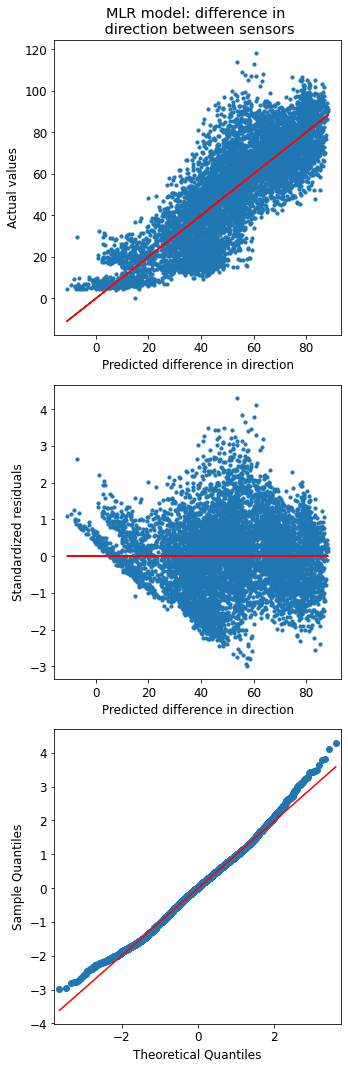

In [58]:
mod = smf.gls(formula='direction_diff ~ speed_avg*environment + distance*environment + control_D_100*environment', data=alldf)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
#print(res.summary())


mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight', rasterized=True)

slope, intercept = np.polyfit(res.fittedvalues, alldf.direction_diff, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: difference in \n direction between sensors')
ax[0].scatter(res.fittedvalues, alldf.direction_diff, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted difference in direction')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted difference in direction')
ax[1].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', ax=ax[2])

plt.show()

fig.savefig('residualplots_direction_spatial.svg', dpi=600, format='svg')

## speed

In [143]:
mod = smf.gls(formula='speed_diff_abs ~ speed_avg*environment + distance*environment + control_S2_100*environment', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:         speed_diff_abs   R-squared:                       0.229
Model:                            GLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     10.11
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           0.000107
Time:                        19:22:49   Log-Likelihood:                -9338.4
No. Observations:                7244   AIC:                         1.869e+04
Df Residuals:                    7236   BIC:                         1.875e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

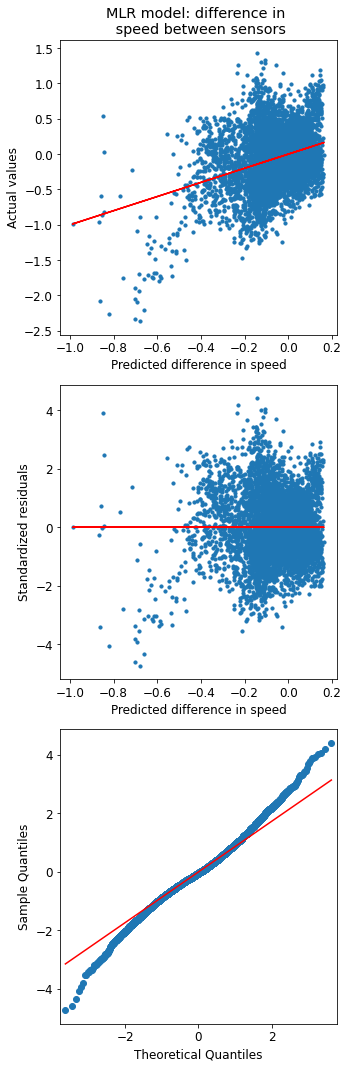

In [62]:
mod = smf.gls(formula='speed_diff ~ speed_avg*environment + distance*environment + control_S2_100*environment', data=alldf)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
#print(res.summary())


mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight', rasterized=True)

slope, intercept = np.polyfit(res.fittedvalues, alldf.speed_diff,1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: difference in \n speed between sensors')
ax[0].scatter(res.fittedvalues, alldf.speed_diff, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted difference in speed')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted difference in speed')
ax[1].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', ax=ax[2])

plt.show()

fig.savefig('residuals_speed_spatial.svg', dpi=600, format='svg')